In [60]:
%run init_notebook.py

In [61]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [62]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [63]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

In [64]:
from statsmodels.regression.linear_model import OLS

In [109]:
df = load_pd_df("df_analysis.feather")

# Macro Time Series Error analysis

## Dräger (2015) rationality test

In [149]:
sub1 = pd_groupby(df.set_index('date_recorded').sort_index(), ['pi_de_Y', 'pi_perc_MY',], 'M', 'last')
sub1 = sub1.diff().dropna()
sub1 = sm.add_constant(sub1)

mod1 = OLS(sub1.pi_de_Y, sub1.drop('pi_de_Y', axis=1)).fit()

In [150]:
sub2 = pd_groupby(df.set_index('date_forecast').sort_index(), ['pi_de_Y', 'pi_exp_MY',], 'M', 'last')
sub2 = sub2.diff().dropna()
sub2 = sm.add_constant(sub2)

mod2 = OLS(sub2.pi_de_Y, sub2.drop('pi_de_Y', axis=1)).fit()

In [113]:
sub3 = pd_groupby(df.set_index('date_forecast').sort_index(), ['pi_de_Y_diff', 'delta_pe_MY',], 'M', 'last')
sub3 = sub3.diff().dropna()
sub3 = sm.add_constant(sub3)

mod3 = OLS(sub3.pi_de_Y_diff, sub3.drop('pi_de_Y_diff', axis=1)).fit()

In [114]:
out = get_statsmodels_summary([mod1, mod2, mod3])
save_pd_df(out, "tab_rationality_test.csv", GRAPHS_DIR)
out

,pi_de_Y,pi_de_Y_1,pi_de_Y_diff
const,-0.0 \n[-0.136],0.001 \n[0.627],0.0 \n[0.186]
delta_pe_MY,NaN,NaN,-0.547 \n[-0.84]
pi_exp_MY,NaN,1.334 ***\n[2.894],NaN
pi_perc_MY,1.618 ***\n[2.889],NaN,NaN
N,32.0,35.0,32.0
R^2,0.218,0.202,0.023
R^2 adj.,0.192,0.178,-0.01


In [152]:
import pymc as pm
import arviz as az

In [157]:
with pm.Model() as mod:
    alpha = pm.Normal('alpha', 0, 10, shape=(1,))
    beta = pm.Normal('beta', 0, 10, shape=(1,))
    sigma = pm.HalfNormal('sigma', 2, shape=(1,))
    
    mu = pm.Deterministic('mu', alpha + sub2.pi_exp_MY.values[:,None] @ beta)
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=sub2.pi_de_Y)
    
    idata = pm.sample(nuts_sampler='numpyro')
    posterior = pm.sample_posterior_predictive(idata)    

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.430818
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Sampling time =  0:00:03.192868
Transforming variables...
Transformation time =  0:00:00.019592


''

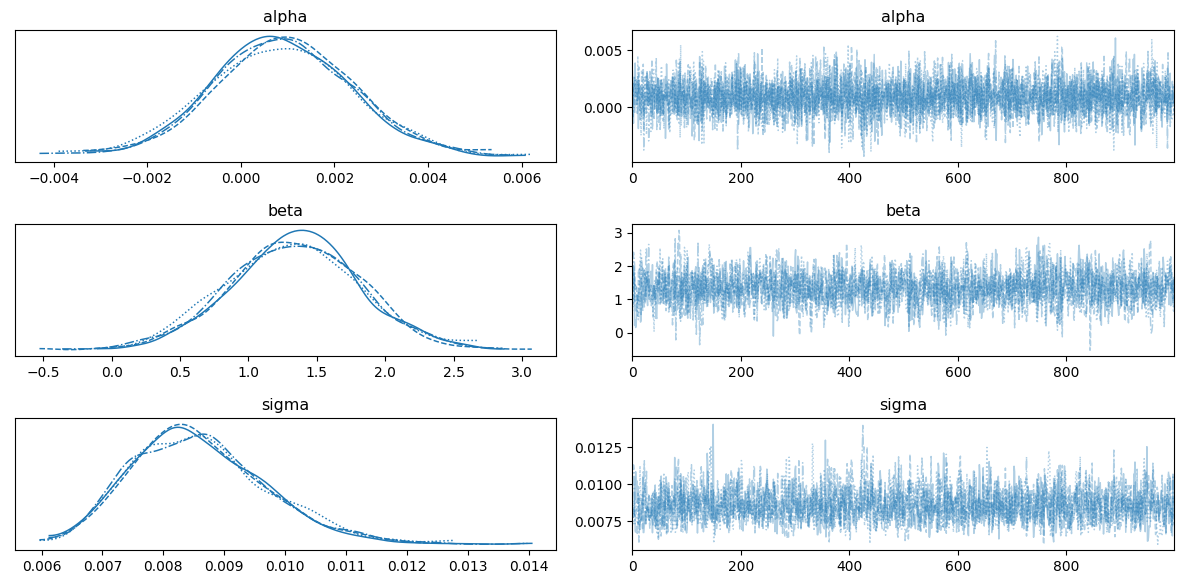

In [158]:
az.plot_trace(idata, var_names=['alpha', 'beta', 'sigma'])
plt.tight_layout()
;

## Cross corr

In [143]:
sub = df.set_index('date_recorded')[
    ['delta_pe_MY_error_act_MY', 'pi_perc_MY_all_error_act_MY', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_de_Y',]
].drop_duplicates()
sub2 = df.set_index('date_recorded')[
    ['delta_pe_MY_error_act_WY', 'pi_perc_MY_all_error_act_WY', 'T_sum_ind_op_diff']
].drop_duplicates()

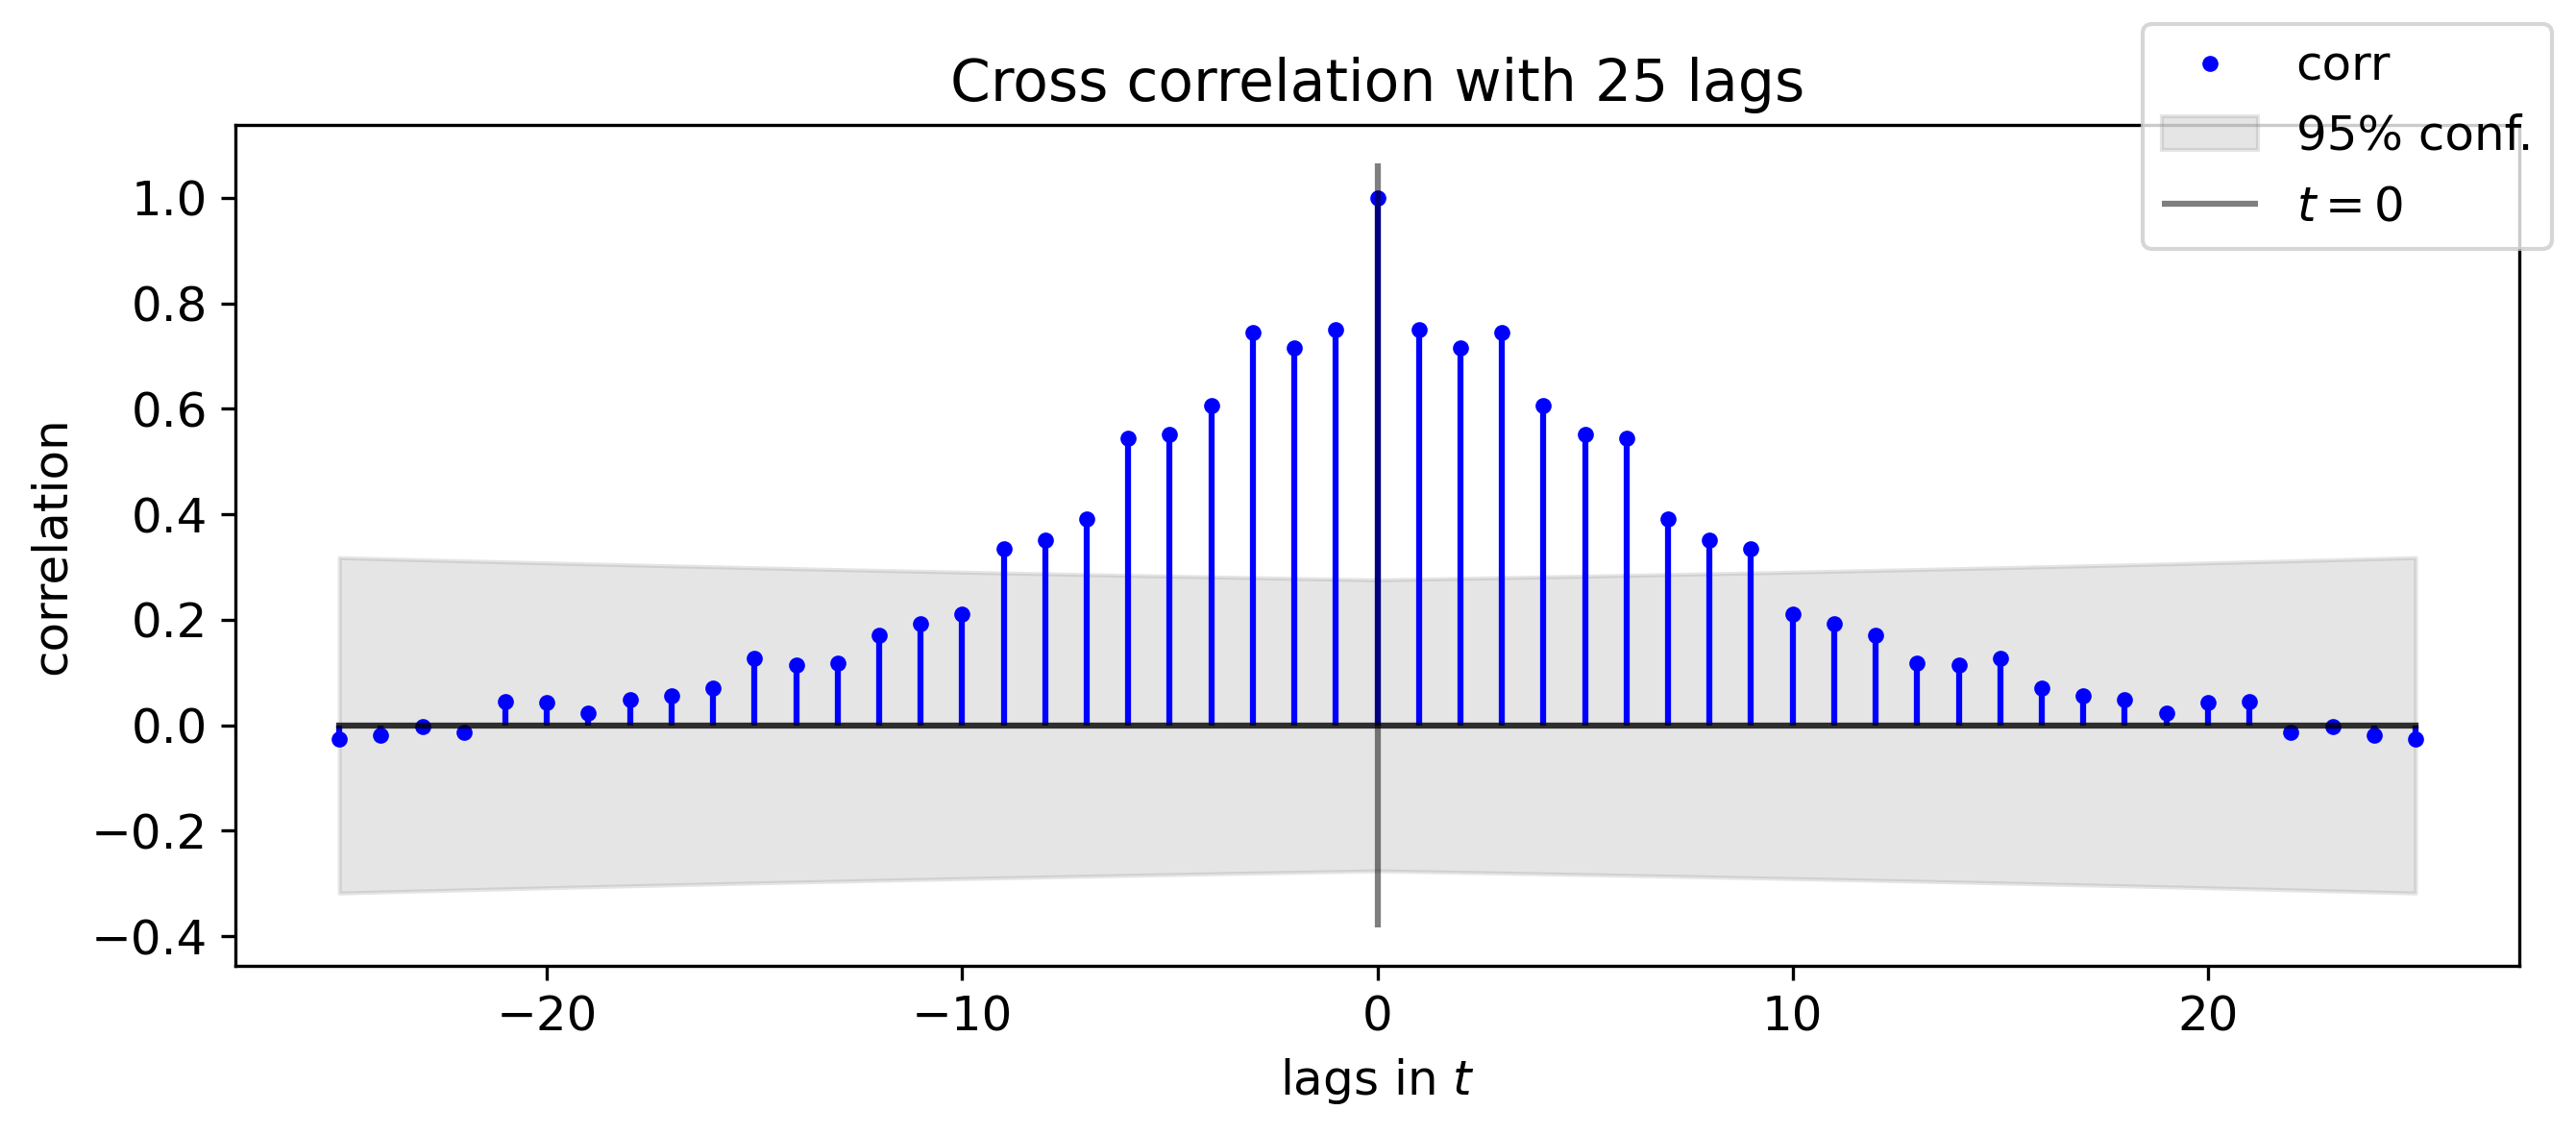

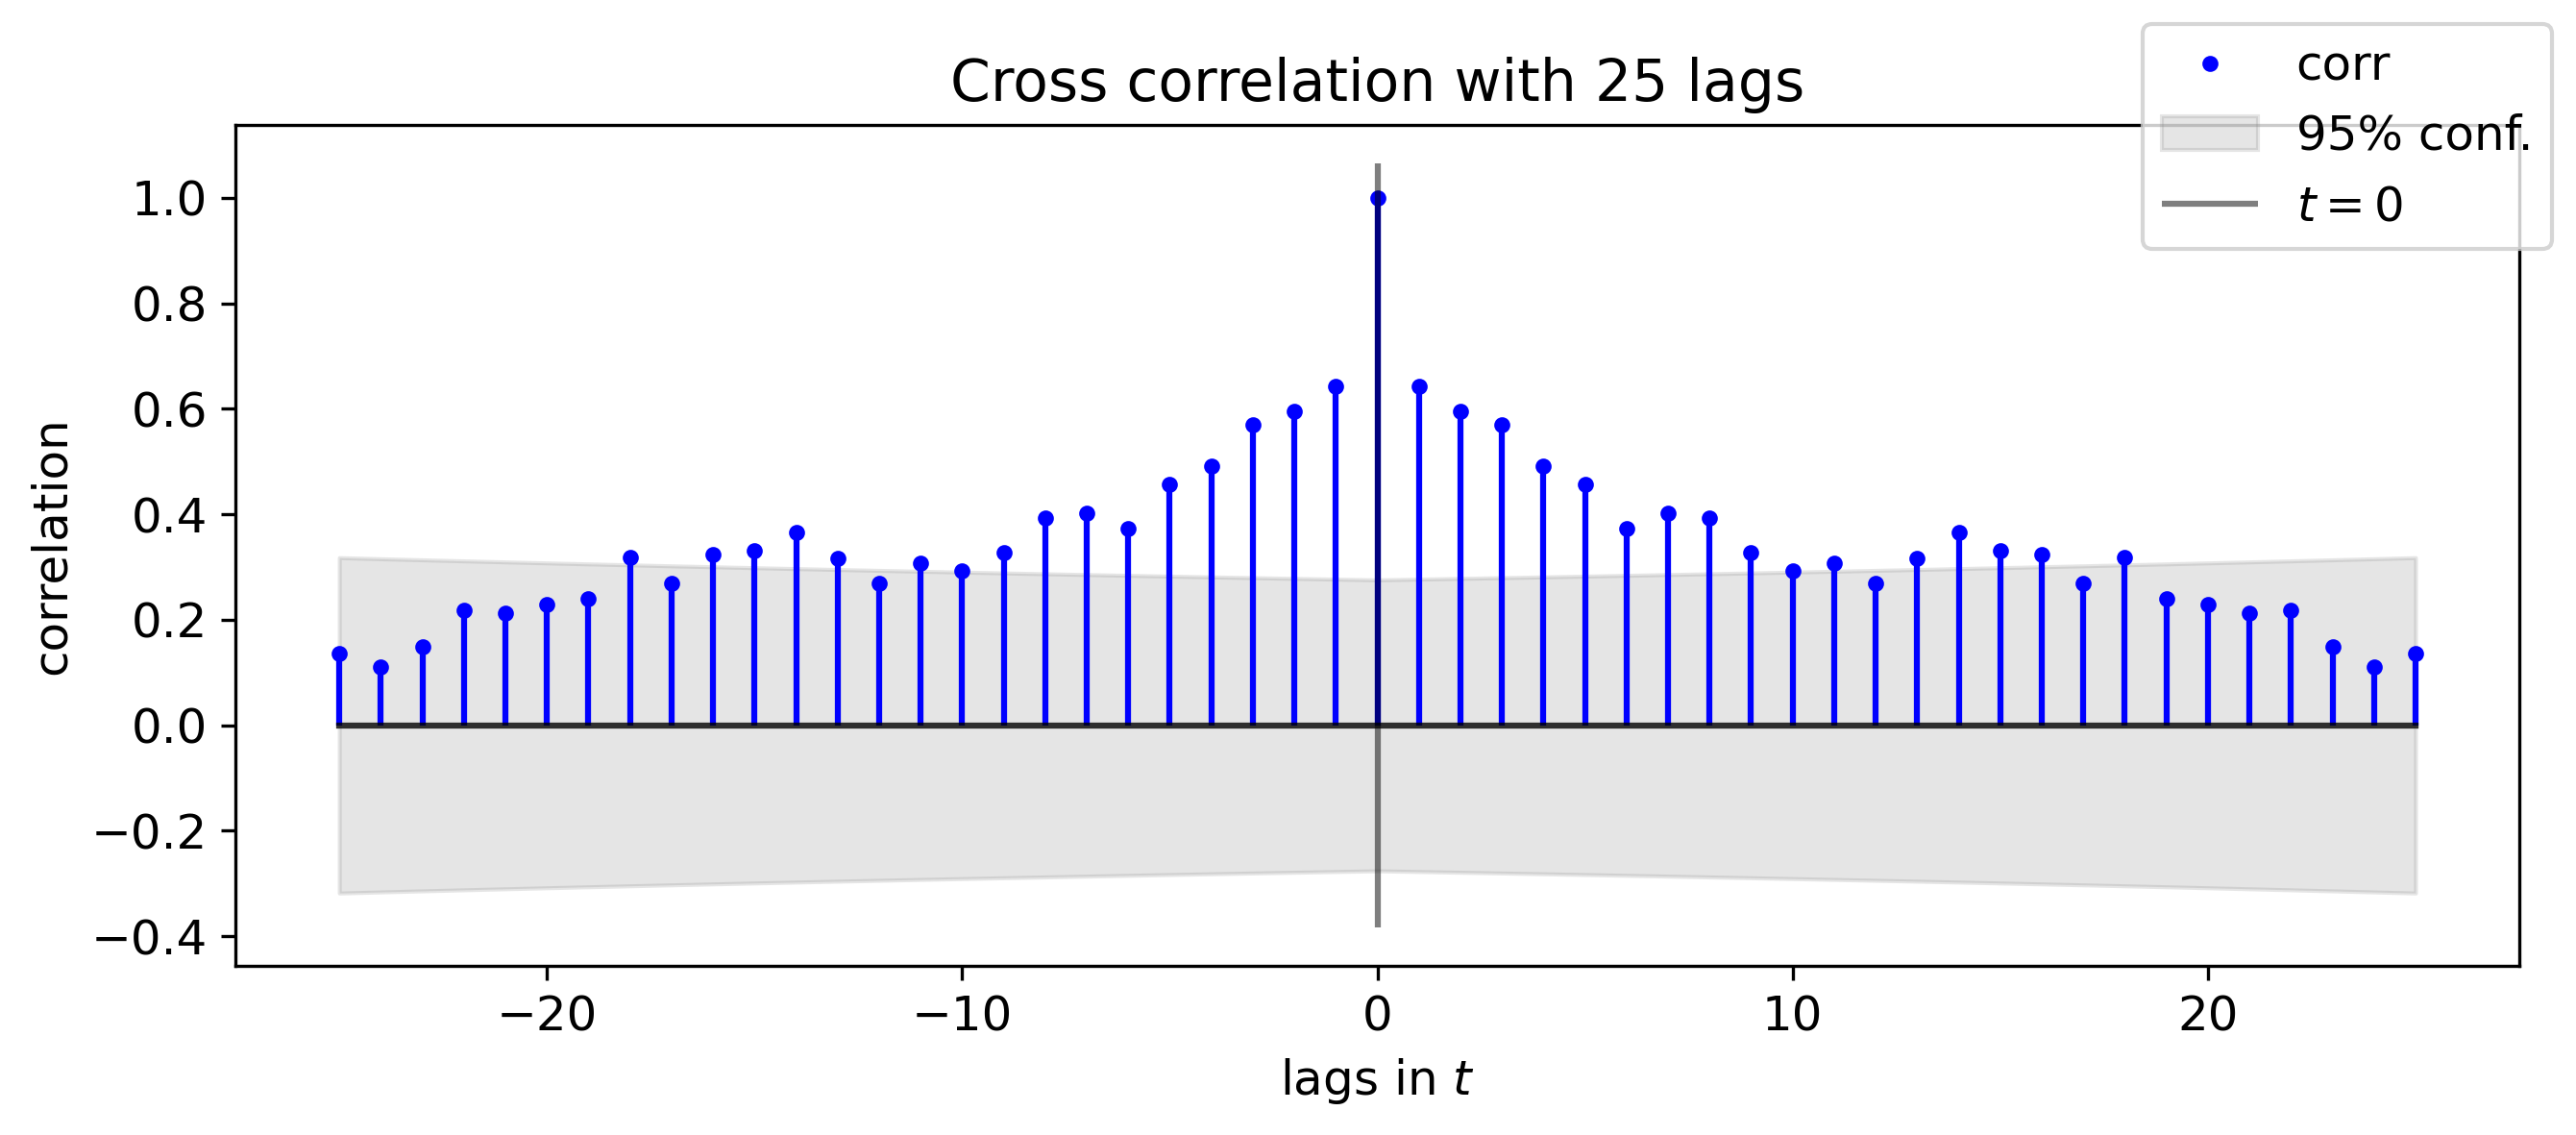

In [72]:
_, _, _, fig = xcorr(sub2.pi_perc_MY_all_error_act_WY, dpi=300, n_lags=25, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_pi_perc_acorr.png')
_, _, _, fig = xcorr(sub2.delta_pe_MY_error_act_WY, dpi=300, n_lags=25, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_delta_pe_acorr.png')

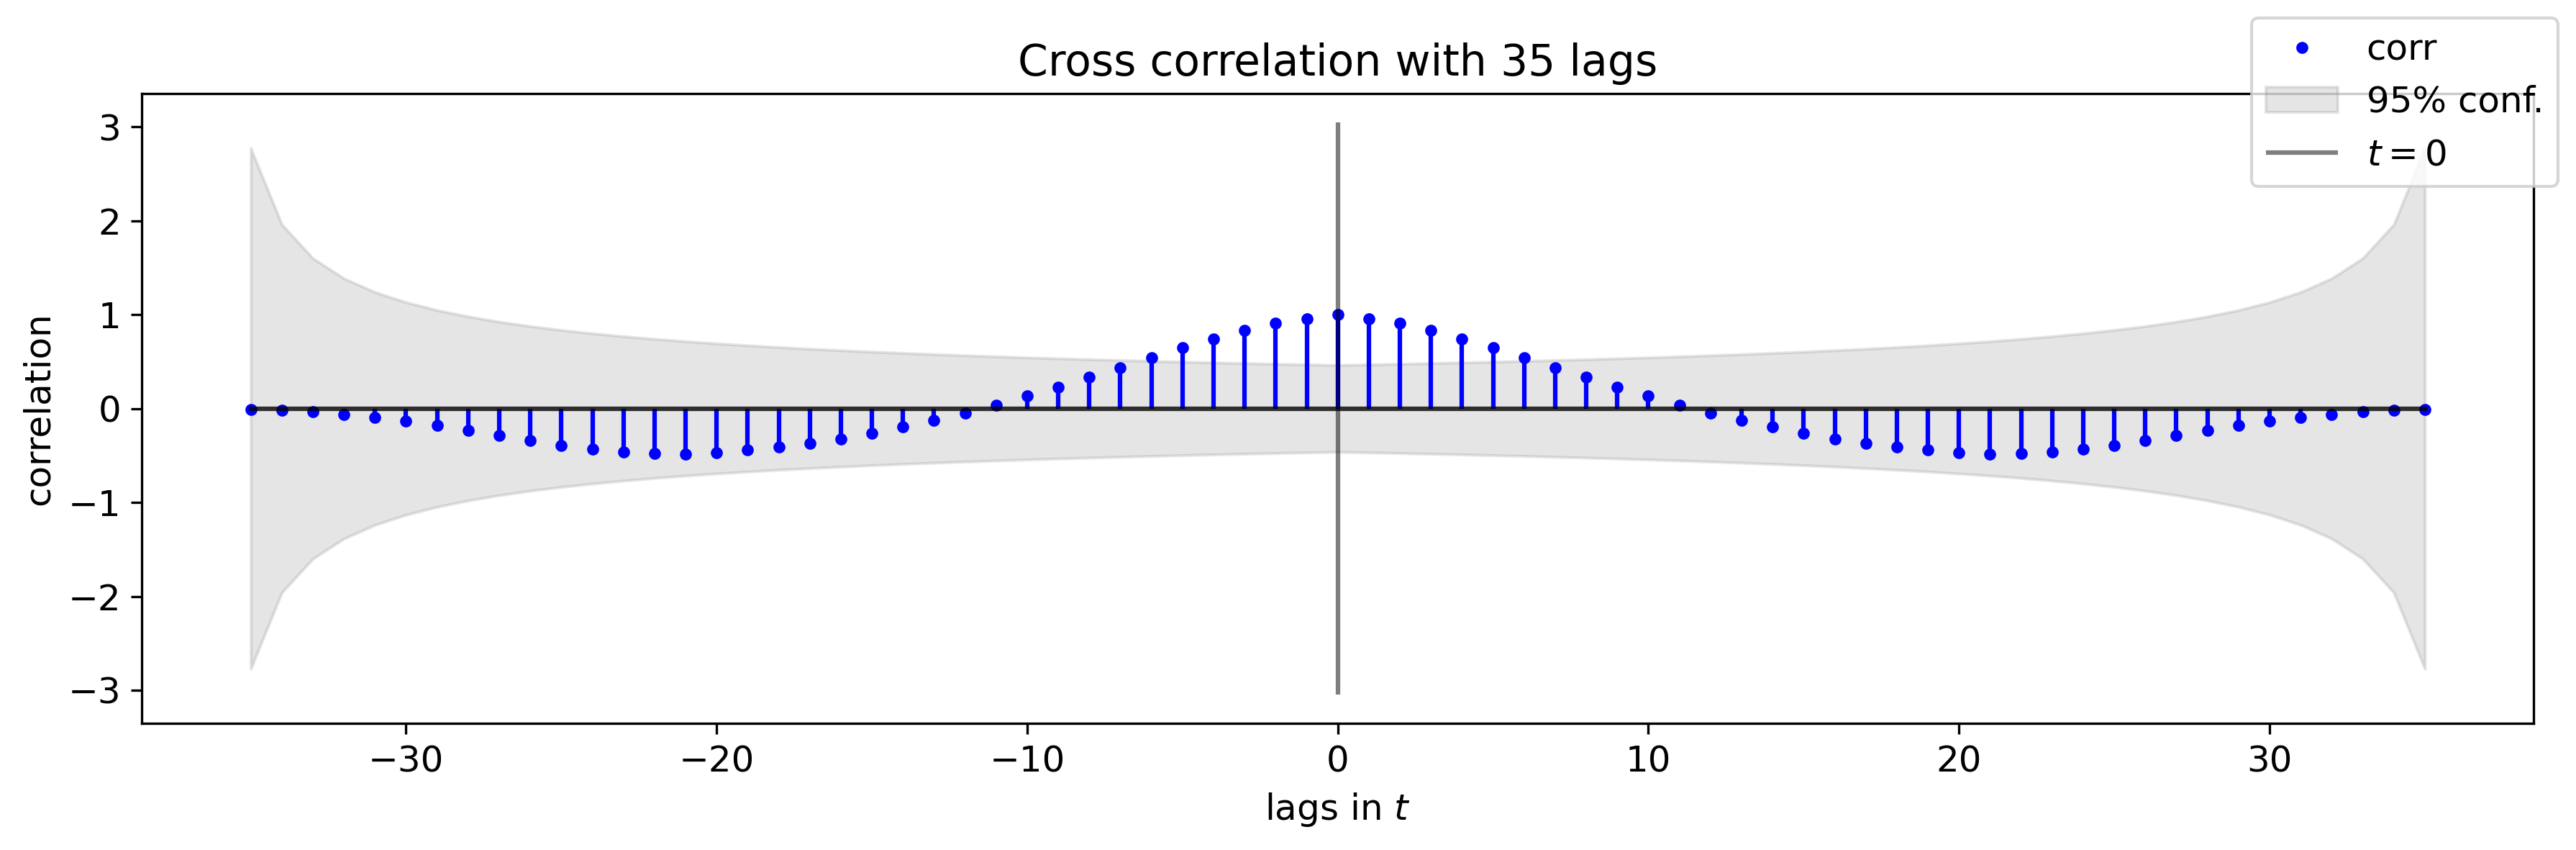

In [73]:
_, _, _, fig = xcorr(sub.pi_de_estimate_Y, dpi=300, n_lags=35, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_pi_structural_acorr.png')

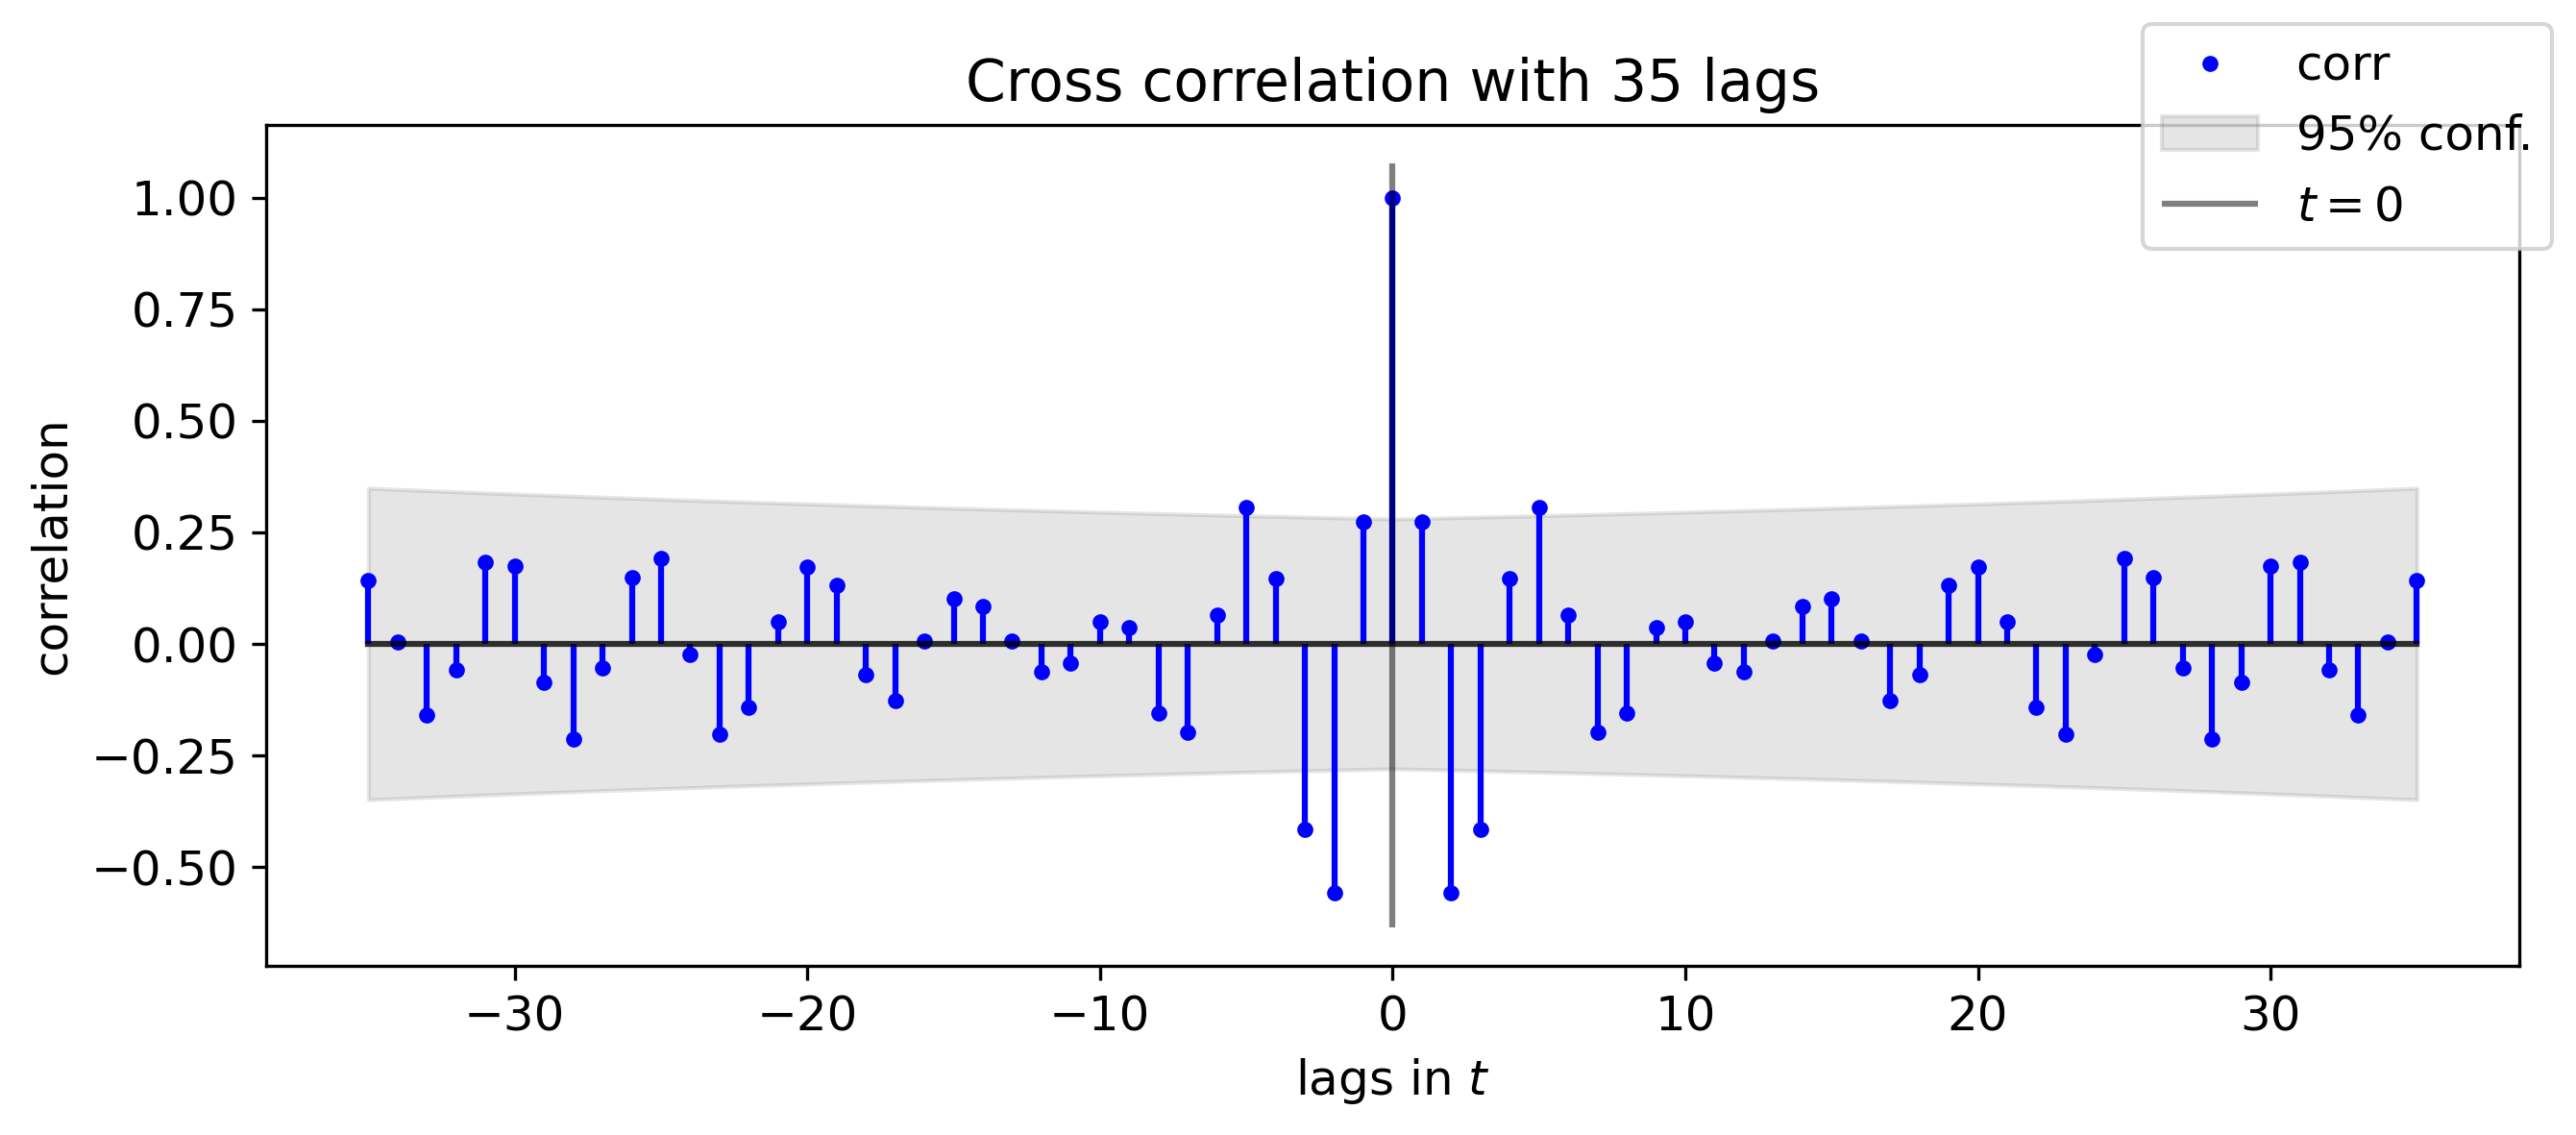

In [144]:
_, _, _, fig = xcorr(sub2.T_sum_ind_op_diff.dropna(), dpi=300, n_lags=35, figsize=(9,4));
fig, ax = fig
save_fig(fig, 'emp_T_sum_acorr.png')

## VECM

In [77]:
df_sub = pd_groupby(df.set_index('date_recorded'), 
                 ['pi_de_surprise_Y', 'delta_pe_MY', 'pi_perc_MY_error_act',
                  'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1', 'pi_perc_MY_S_error_act',
                  'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum_ind_op', 'T_sum_raw']
                 , 'M', 'last')
df_sub = pd_join_freq(df_sub,
             pd_groupby(df.set_index('date_recorded'), ['delta_pe_MY_error_act_MY', 'pi_perc_uncertainty_MY',], 'M', 'mean'),
             'M',
            )
df_sub['pi_perc_MY_error_act'] /= 100
df_sub['delta_pe_MY_error_act_MY'] /= 10
t_sum_var = 'T_sum_ind_op'

### pi perc

In [78]:
cols_endog, cols_exog = ['pi_perc_MY'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY',]
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2, deterministic='ci')
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm1.summary()

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum_ind_op ADF p-val: 0.906058472555874
pi_de_surprise_Y ADF p-val: 0.10964410772978911
pi_de_estimate_Y ADF p-val: 0.5890090275327853
pi_exp_MY ADF p-val: 0.14479079097337977
4
2 0


### pi perc error

In [79]:
cols_endog, cols_exog = ['pi_perc_MY_error_act'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY',]
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 3) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm2.summary()

pi_perc_MY_error_act ADF p-val: 1.974540165527414e-08
T_sum_ind_op ADF p-val: 0.9283540570773853
pi_de_surprise_Y ADF p-val: 0.29697134223635535
pi_de_estimate_Y ADF p-val: 0.7775251260405094
pi_exp_MY ADF p-val: 0.2551156035612694
3
3 0


### delta pe

In [80]:
cols_endog, cols_exog = ['delta_pe_MY'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 3) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

delta_pe_MY ADF p-val: 0.5619457365131322
T_sum_ind_op ADF p-val: 0.906058472555874
pi_de_surprise_Y ADF p-val: 0.10964410772978911
pi_de_estimate_Y ADF p-val: 0.5890090275327853
pi_exp_MY ADF p-val: 0.14479079097337977
5
3 1


### delta pe error

In [81]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], [t_sum_var, 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm4.summary()

delta_pe_MY_error_act_MY ADF p-val: 0.5446227785790462
T_sum_ind_op ADF p-val: 0.9283540570773853
pi_de_surprise_Y ADF p-val: 0.29697134223635535
pi_de_estimate_Y ADF p-val: 0.7775251260405094
pi_exp_MY ADF p-val: 0.2551156035612694
3
2 0


### pi perc S

In [82]:
cols_endog, cols_exog = ['pi_perc_MY'], [t_sum_var, 'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1', 'pi_exp_MY', ]
sub = df_sub[cols_endog+cols_exog].dropna().copy()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 3) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm1.summary()

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum_ind_op ADF p-val: 0.906058472555874
pi_de_surprise_Y_lead1 ADF p-val: 0.24946359680678376
pi_de_estimate_Y_lead1 ADF p-val: 0.7867507163884697
pi_exp_MY ADF p-val: 0.14479079097337977
4
3 3


### pi error S

In [83]:
cols_endog, cols_exog = ['pi_perc_MY_S_error_act'], [t_sum_var, 'pi_de_surprise_Y_lead1', 'pi_de_estimate_Y_lead1', 'pi_exp_MY']
sub = df_sub[cols_endog+cols_exog].dropna()

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 4) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm6 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm2.summary()

pi_perc_MY_S_error_act ADF p-val: 5.314272487890989e-05
T_sum_ind_op ADF p-val: 0.9283540570773853
pi_de_surprise_Y_lead1 ADF p-val: 0.40575633837933295
pi_de_estimate_Y_lead1 ADF p-val: 0.8003606318626139
pi_exp_MY ADF p-val: 0.2551156035612694
4
2 0


### summary

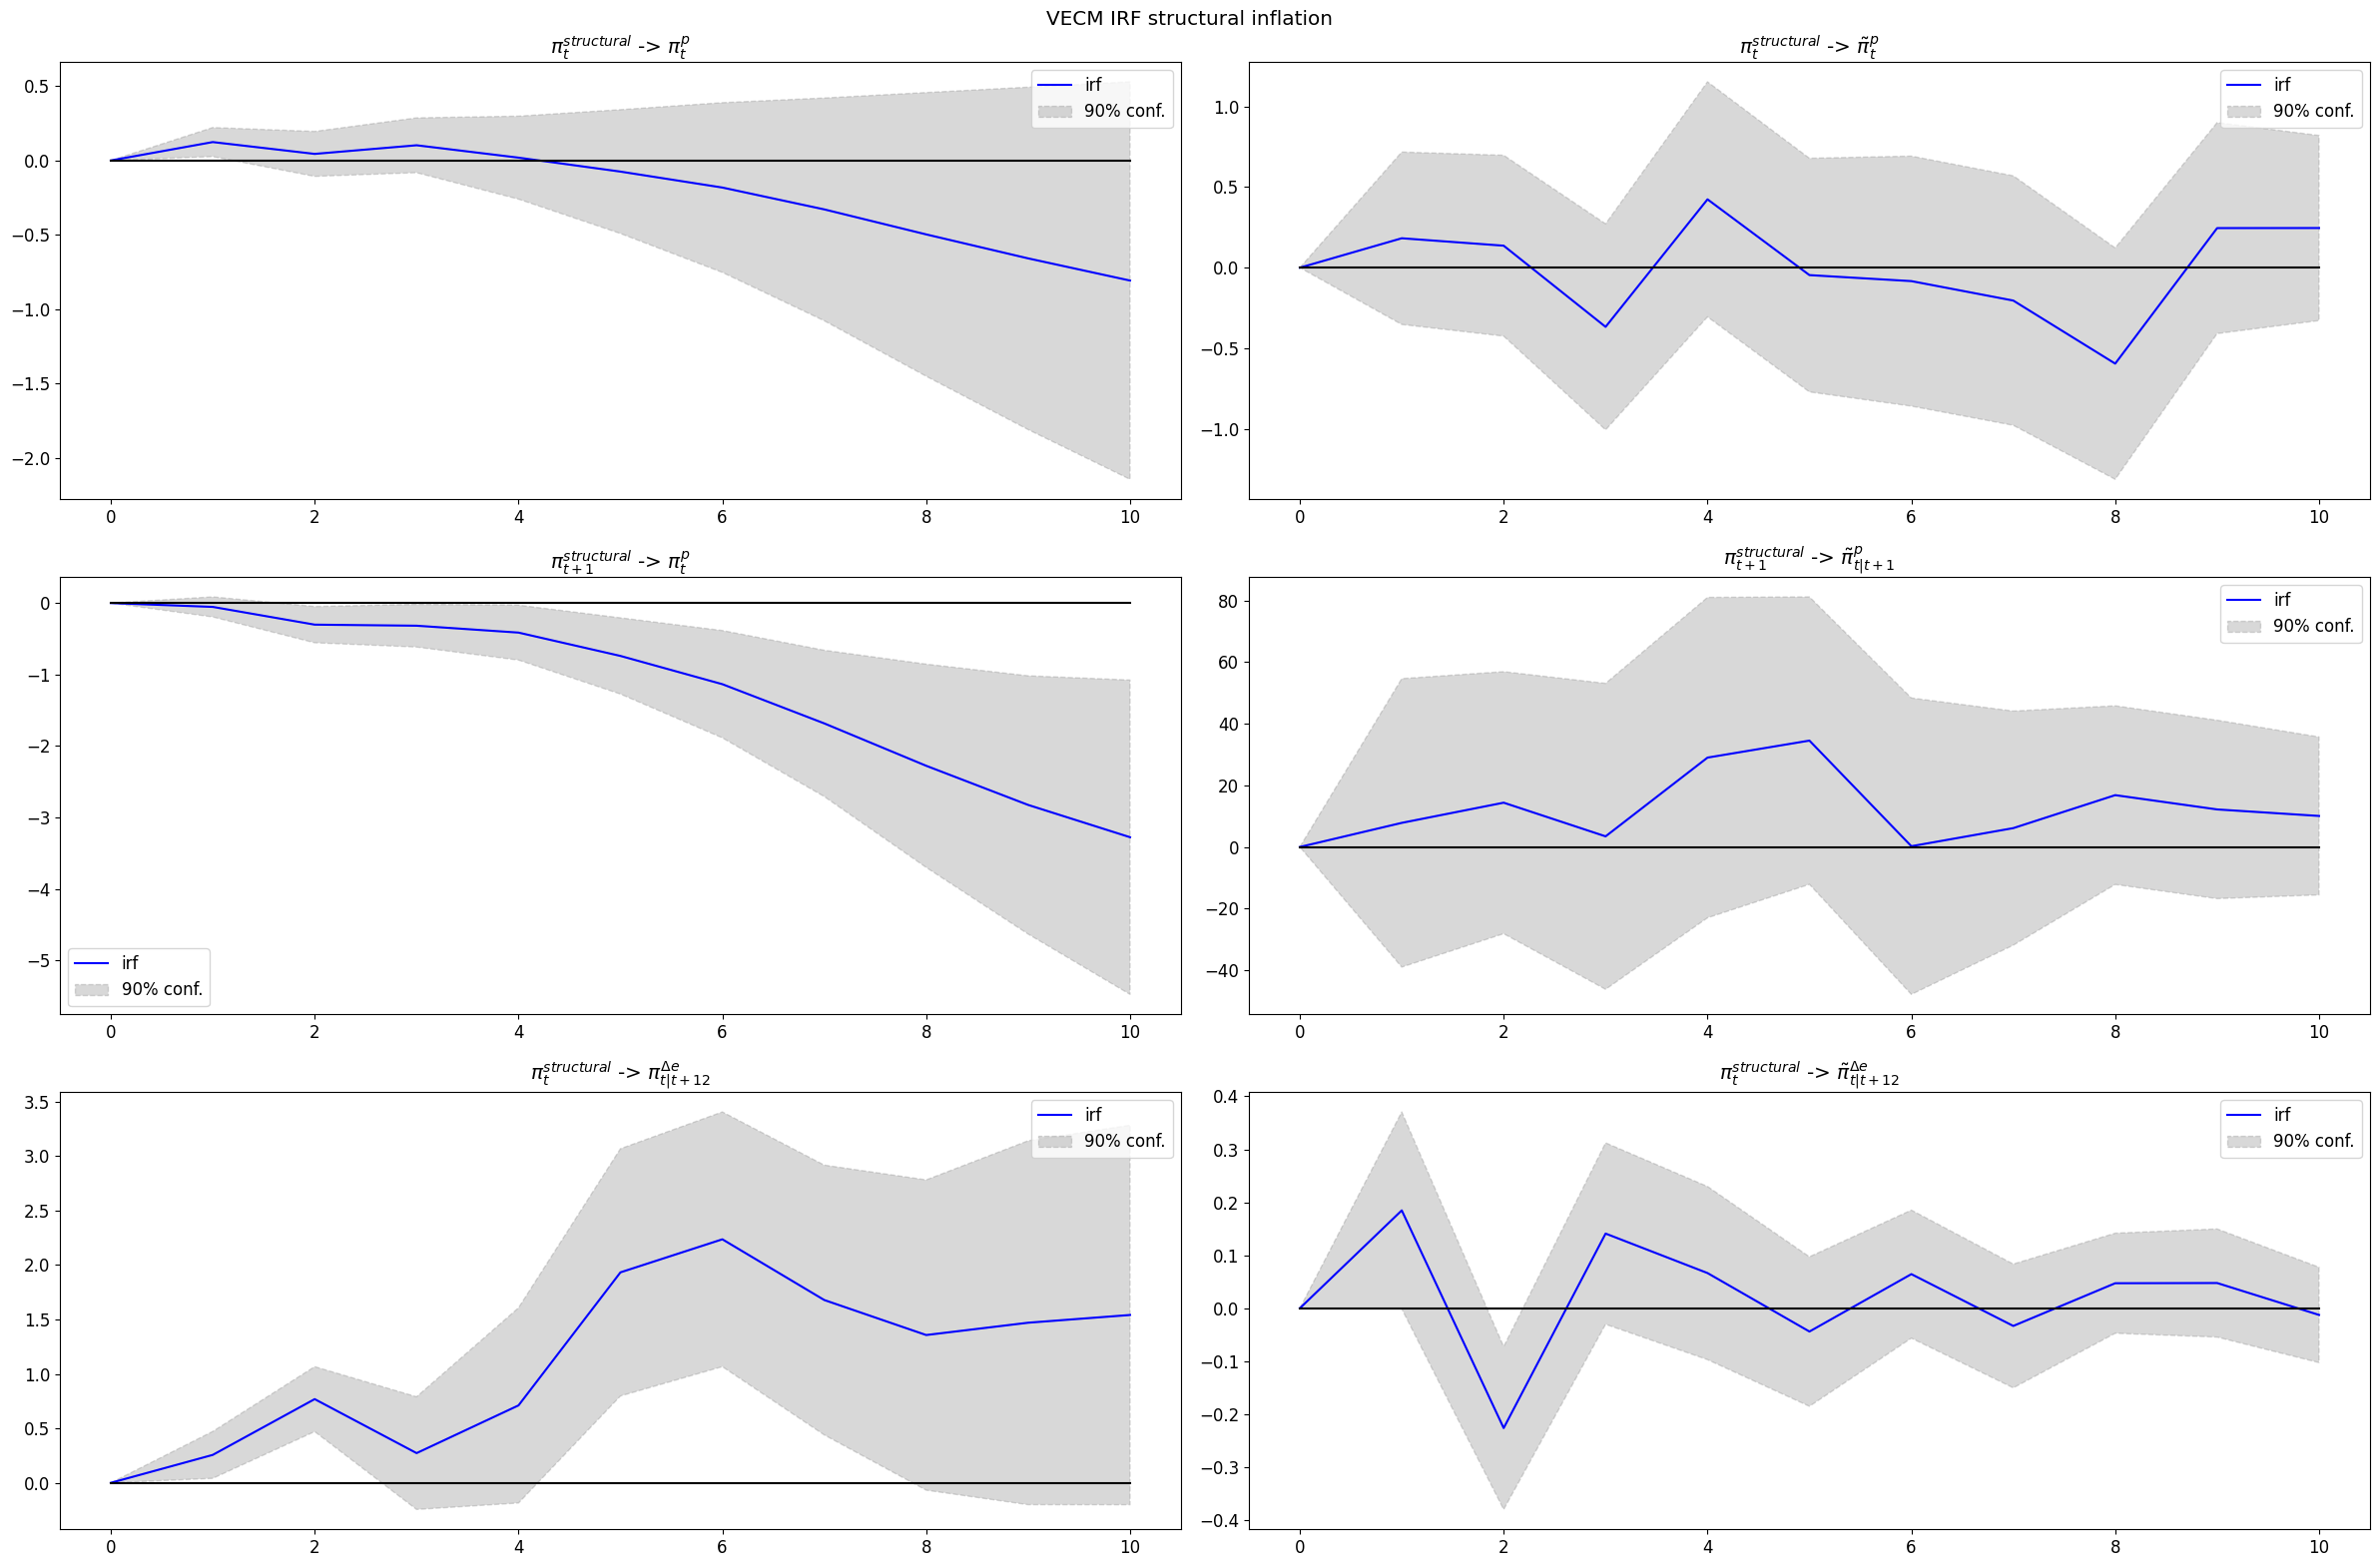

In [84]:
lst_vecms = [vecm1, vecm2, vecm5, vecm6, vecm3, vecm4]
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_de_estimate_Y": "$\pi^{structural}_t$",
                                          "pi_de_estimate_Y_lead1": "$\pi^{structural}_{t+1}$",
                                          "pi_perc_MY_S_error_act": "$\~{\pi}^p_{t|t+1}$",
                                         },
                             idx_vecm=(0, 3),
                             n_cols=2,
                             irf_periods=10,
                            figsize=(8,8),);
fig.suptitle("VECM IRF structural inflation")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news_pi_struct.png")

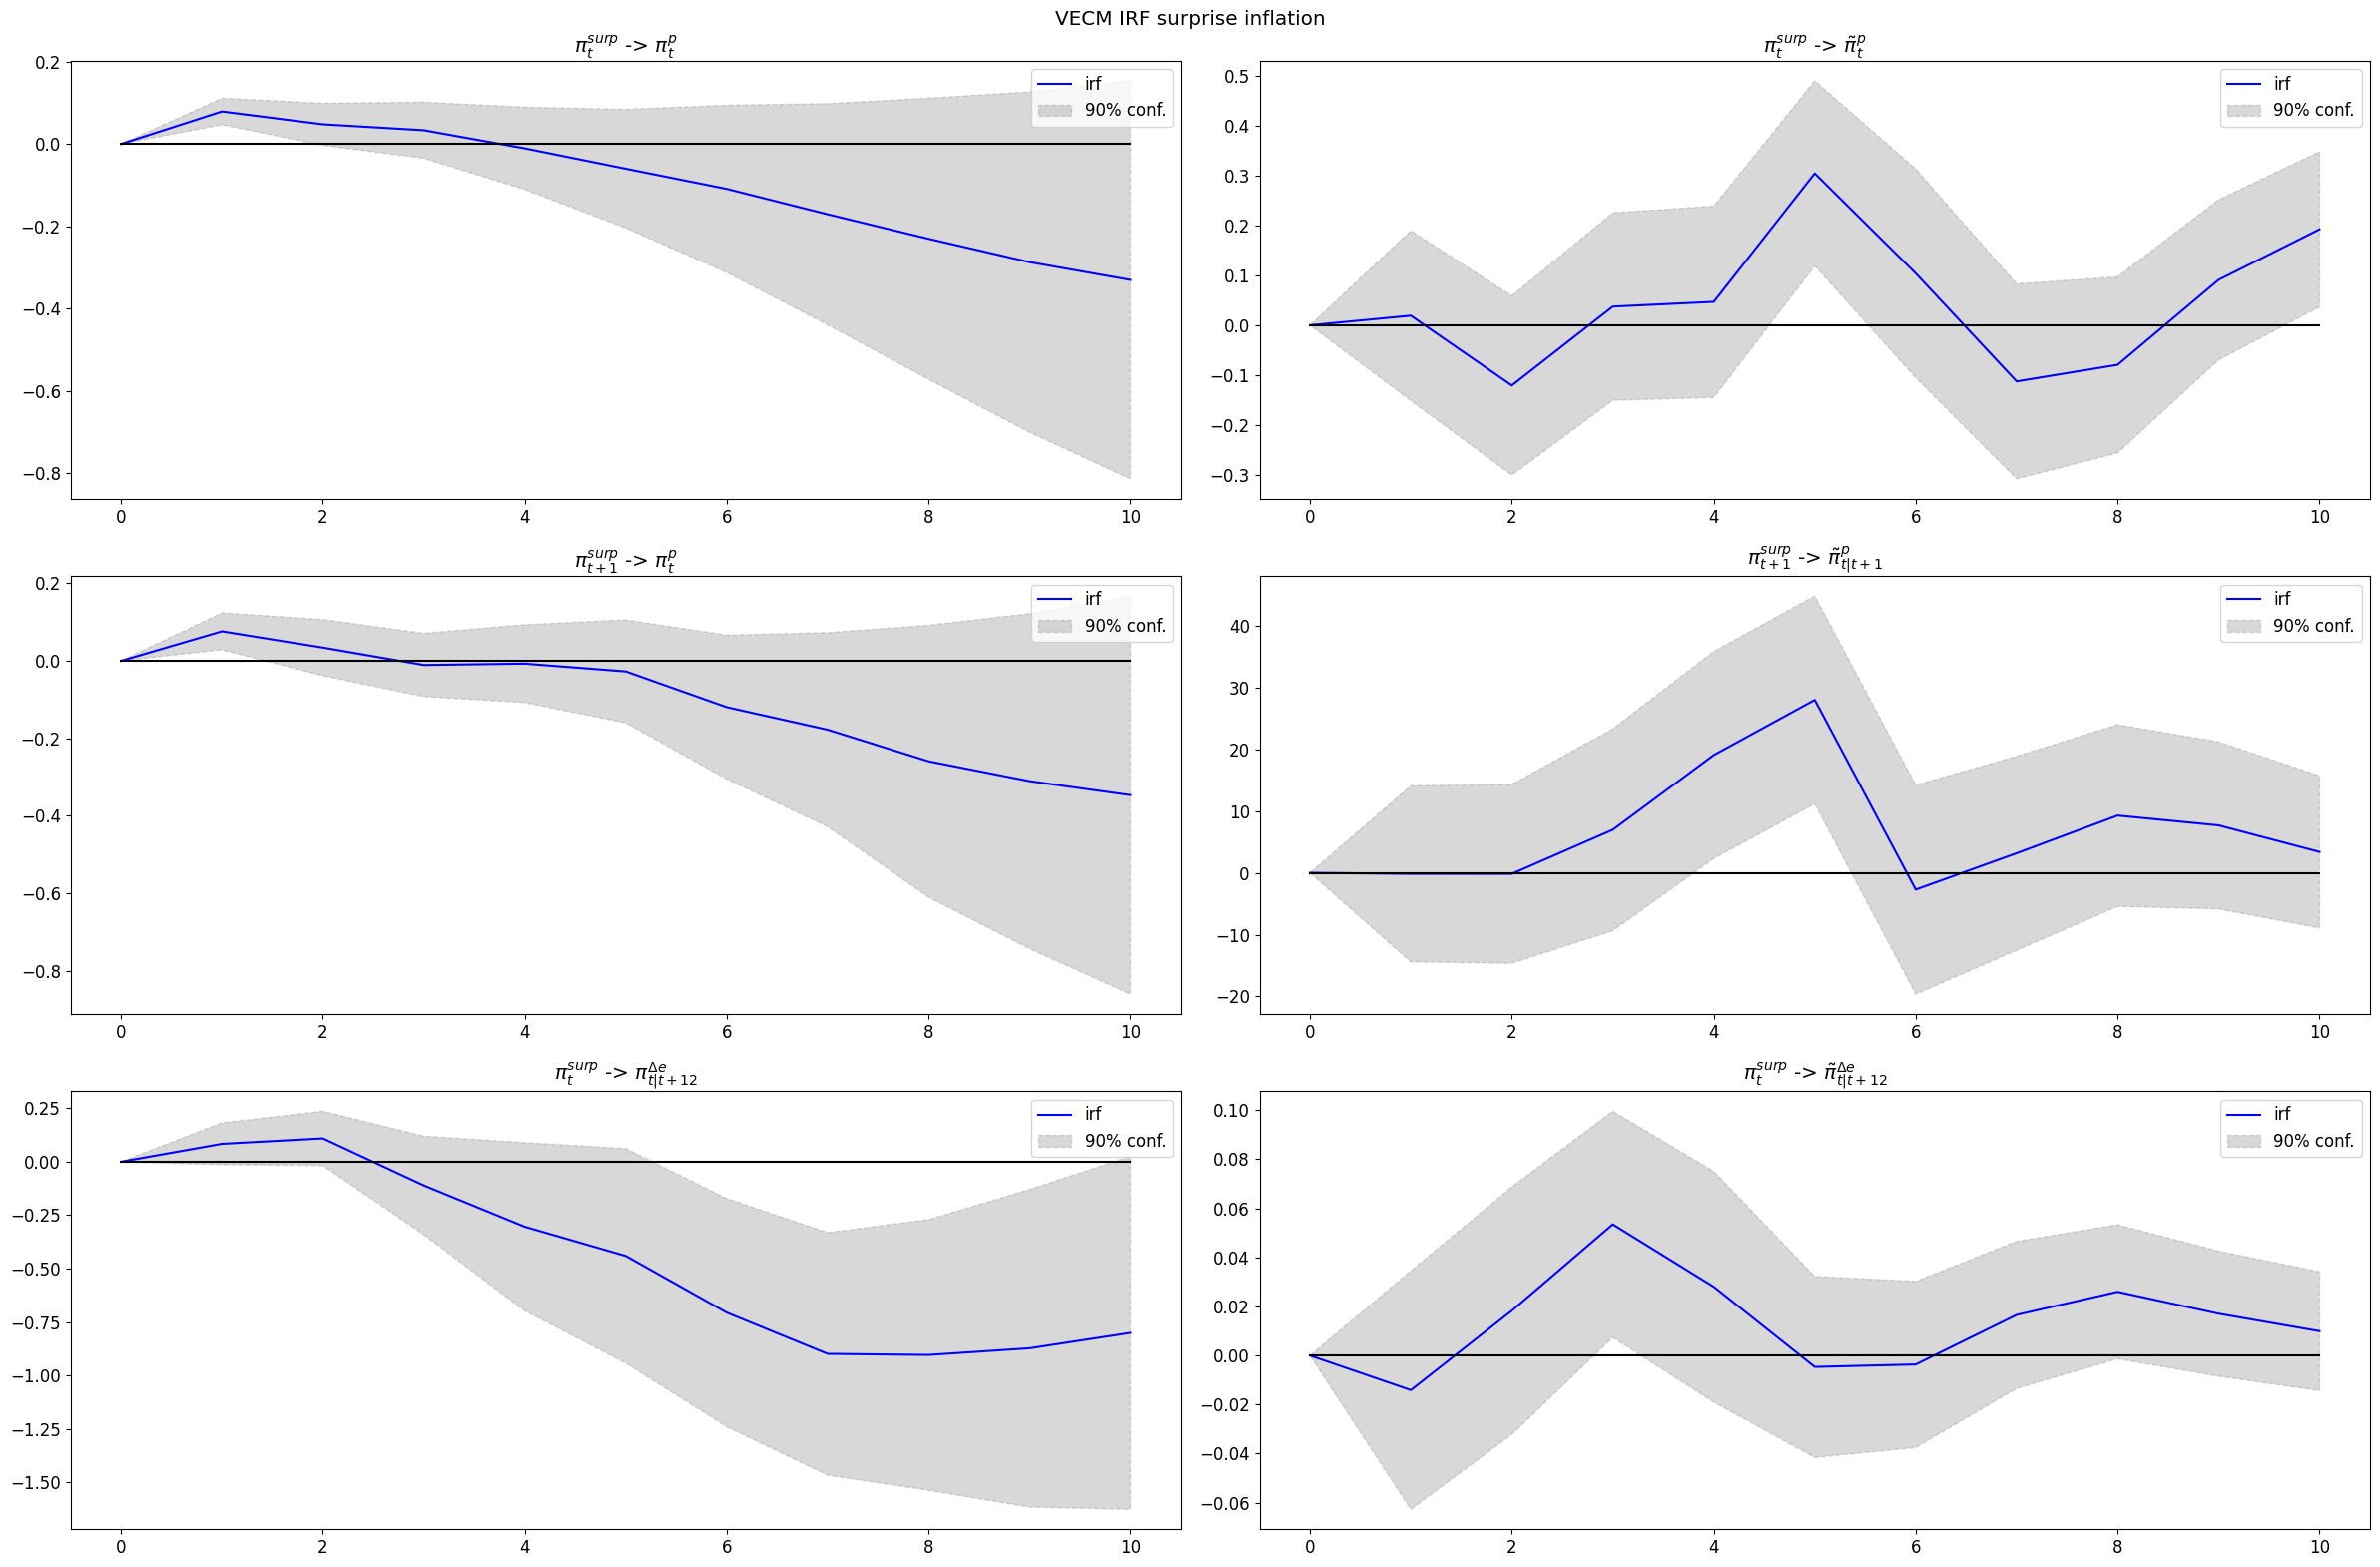

In [85]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "pi_de_surprise_Y_lead1": "$\pi^{surp}_{t+1}$",
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_perc_MY_S_error_act": "$\~{\pi}^p_{t|t+1}$",
                                         },
                             idx_vecm=(0,2),
                             n_cols=2, 
                             irf_periods=10,
                            figsize=(8,8),);
fig.suptitle("VECM IRF surprise inflation")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news_pi_surp.png", GRAPHS_DIR)

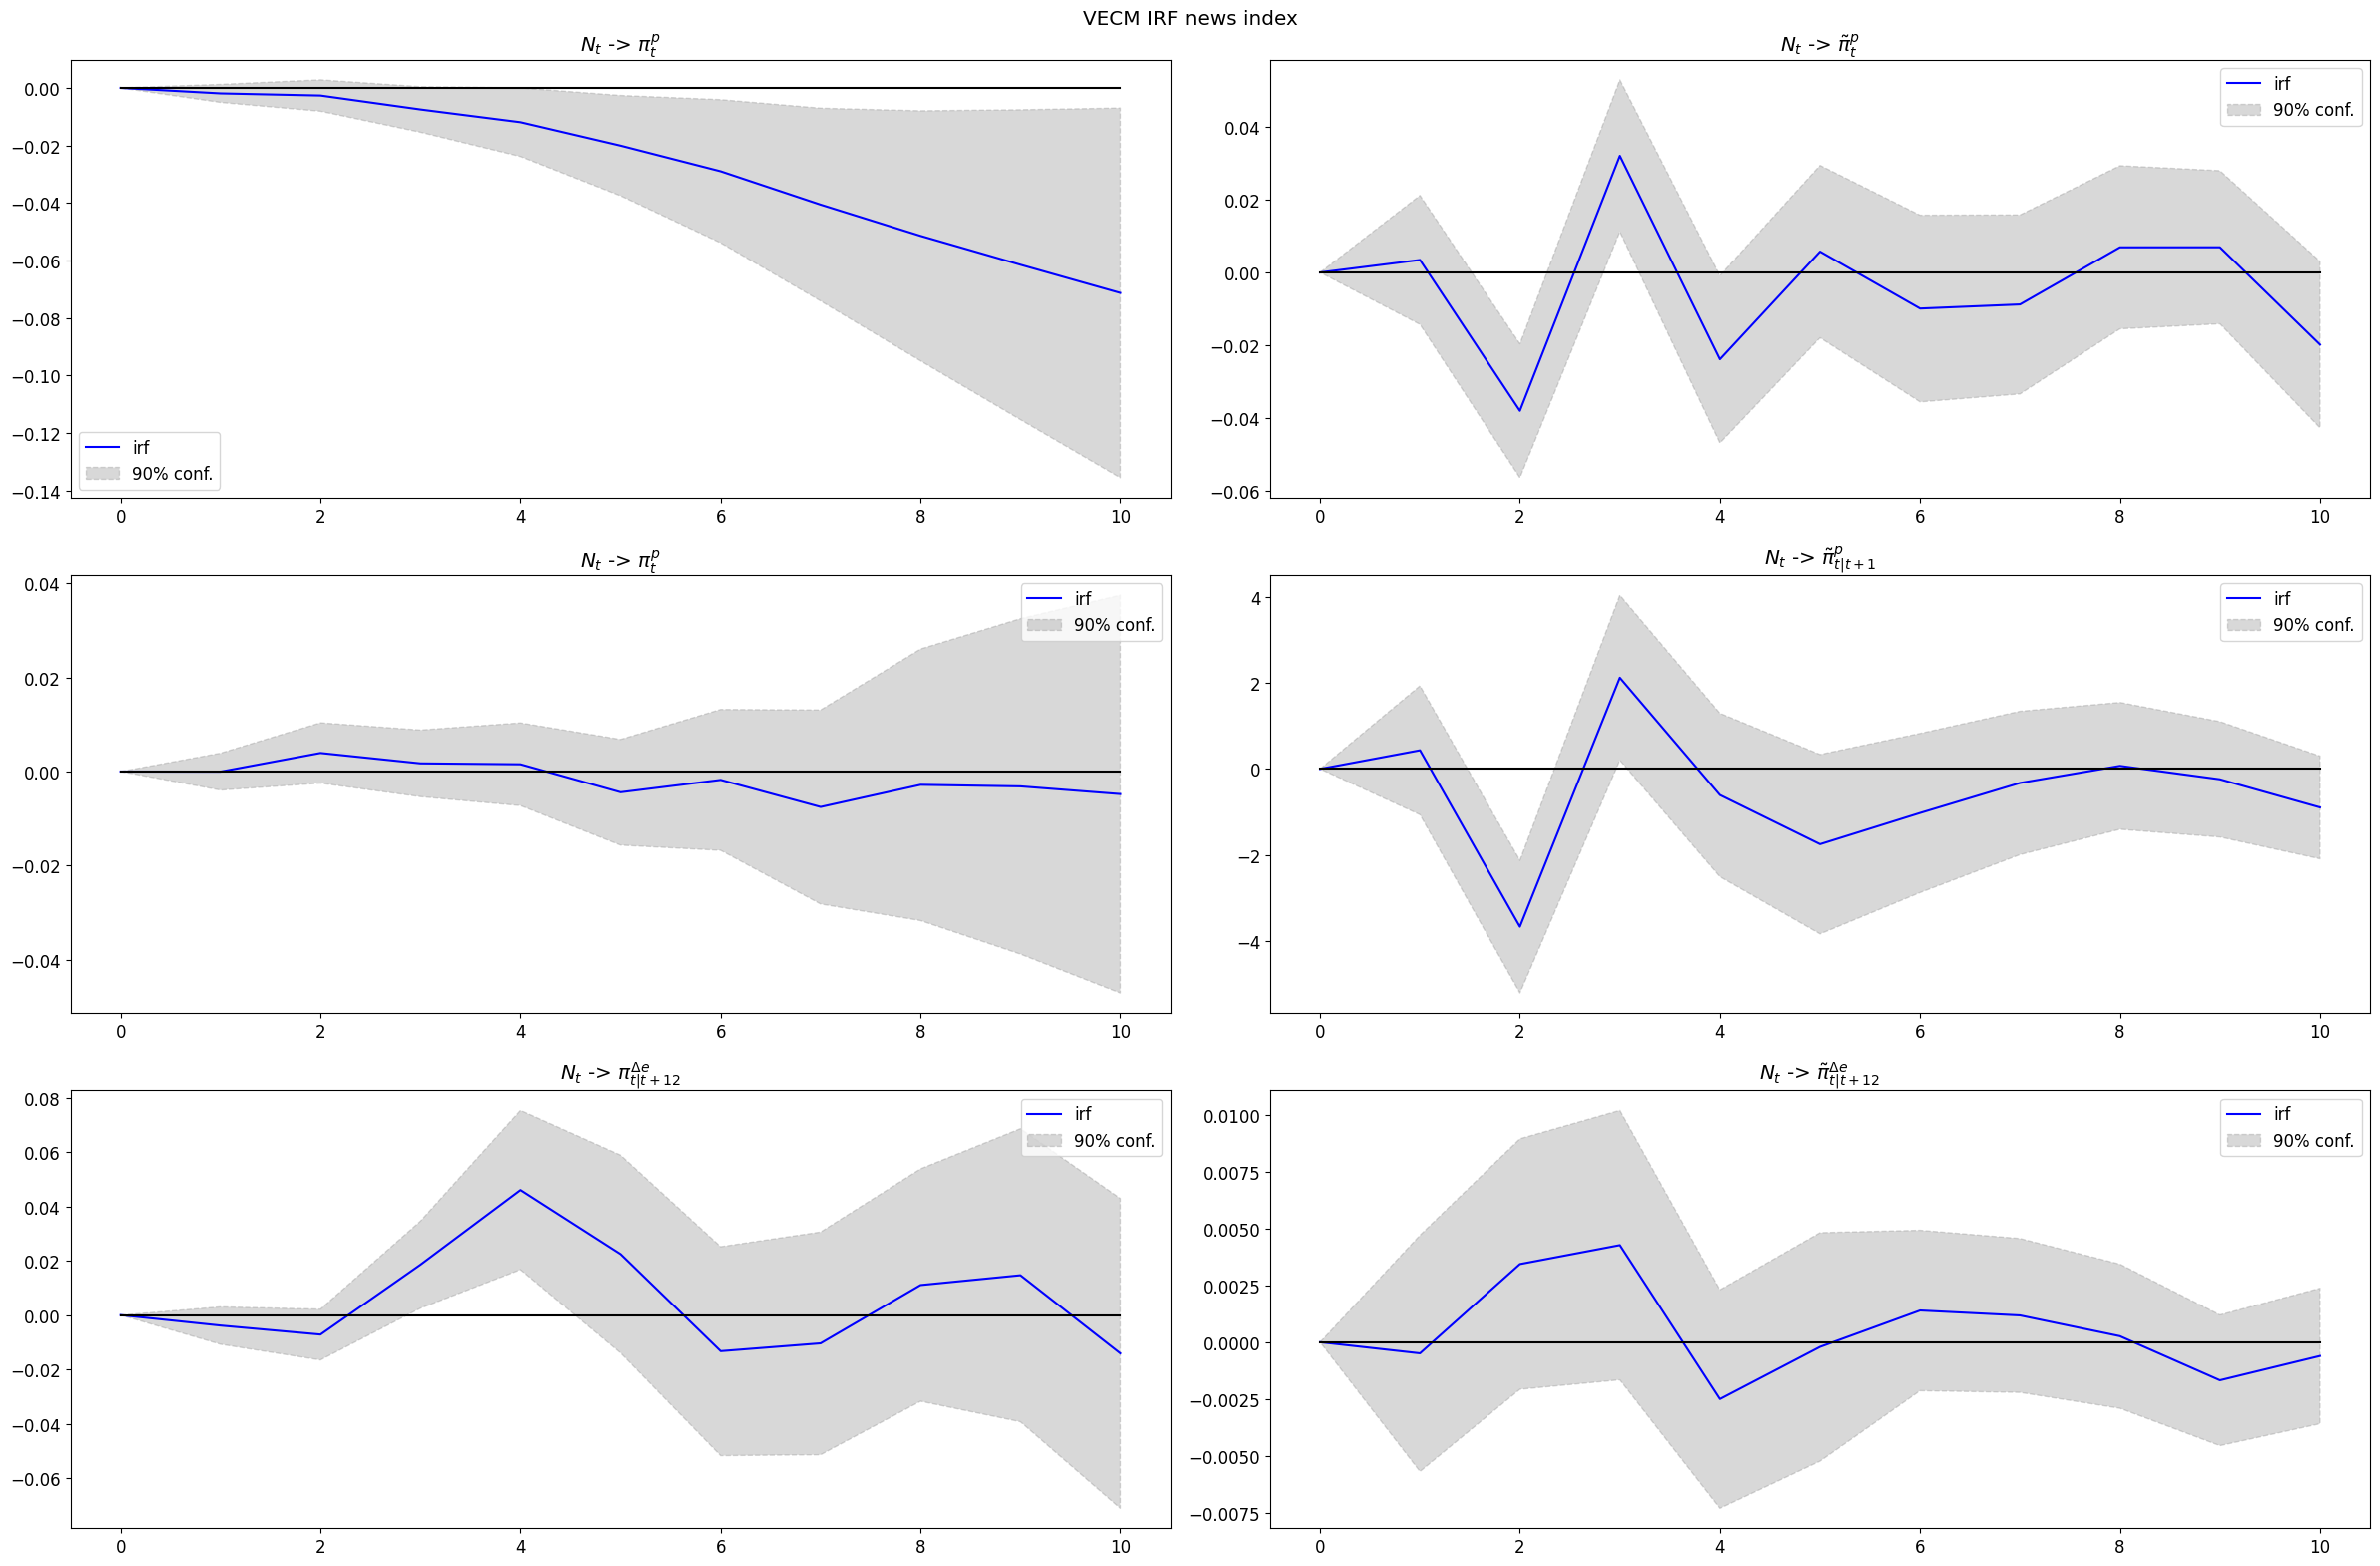

In [86]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum_ind_op": "$N_t$",
                                          "delta_pe_MY_error_act_MY": '$\~{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$",
                                          "pi_uncertainty_MY": "$\pi^{pu}_t$",
                                          "pi_perc_MY_S_error_act": "$\~{\pi}^p_{t|t+1}$",
                                         },
                             n_cols=2,
                             irf_periods=10,
                            figsize=(8,8),);
fig.suptitle("VECM IRF news index")
fig.tight_layout()
save_fig(fig, "emp_vecm_error_news.png")

In [164]:
out = get_statsmodels_summary(lst_vecms, seperator="\n", is_filt_sig=True)
save_pd_df(out, 'tab_vecm_news_resid.csv', GRAPHS_DIR)

In [165]:
out

,delta_pe_MY,delta_pe_MY_error_act_MY,pi_perc_MY,pi_perc_MY_2,pi_perc_MY_S_error_act,pi_perc_MY_error_act
L2.pi_de_surprise_Y,0.3892 ***\n[3.319],-0.0089 \n[-0.188],-0.013 \n[-0.486],NaN,NaN,0.1255 \n[0.575]
L3.pi_de_surprise_Y,0.146 **\n[2.391],NaN,NaN,NaN,NaN,0.0311 \n[0.206]
L3.pi_de_estimate_Y_lead1,NaN,NaN,NaN,-0.1753 ***\n[-3.482],NaN,NaN
L3.delta_pe_MY,-0.3204 **\n[-2.427],NaN,NaN,NaN,NaN,NaN
L3.T_sum_ind_op,-0.0194 ***\n[-4.768],NaN,NaN,-0.008 ***\n[-3.812],NaN,0.0197 *\n[1.86]
L2.pi_perc_MY_error_act,NaN,NaN,NaN,NaN,NaN,0.633 ***\n[2.808]
L2.pi_exp_MY,-1.083 ***\n[-3.724],0.181 \n[1.023],-0.2573 **\n[-2.14],-0.3428 *\n[-1.674],37.3555 \n[0.744],1.4423 *\n[1.789]
L2.pi_de_surprise_Y_lead1,NaN,NaN,NaN,-0.1995 ***\n[-3.475],-14.2369 \n[-1.038],NaN
L2.pi_de_estimate_Y_lead1,NaN,NaN,NaN,-0.205 ***\n[-3.321],-27.0656 \n[-1.483],NaN
L3.pi_de_surprise_Y_lead1,NaN,NaN,NaN,-0.1093 ***\n[-3.263],NaN,NaN


In [163]:
out

,delta_pe_MY,delta_pe_MY_error_act_MY,pi_perc_MY,pi_perc_MY_2,pi_perc_MY_S_error_act,pi_perc_MY_error_act
L2.pi_de_surprise_Y,0.3892 ***\n[3.319],-0.0089 \n[-0.188],-0.013 \n[-0.486],NaN,NaN,0.1255 \n[0.575]
L3.pi_de_surprise_Y,0.146 **\n[2.391],NaN,NaN,NaN,NaN,0.0311 \n[0.206]
L3.pi_de_estimate_Y_lead1,NaN,NaN,NaN,-0.1753 ***\n[-3.482],NaN,NaN
L3.delta_pe_MY,-0.3204 **\n[-2.427],NaN,NaN,NaN,NaN,NaN
L3.T_sum_ind_op,-0.0194 ***\n[-4.768],NaN,NaN,-0.008 ***\n[-3.812],NaN,0.0197 *\n[1.86]
L2.pi_perc_MY_error_act,NaN,NaN,NaN,NaN,NaN,0.633 ***\n[2.808]
L2.pi_exp_MY,-1.083 ***\n[-3.724],0.181 \n[1.023],-0.2573 **\n[-2.14],-0.3428 *\n[-1.674],37.3555 \n[0.744],1.4423 *\n[1.789]
L2.pi_de_surprise_Y_lead1,NaN,NaN,NaN,-0.1995 ***\n[-3.475],-14.2369 \n[-1.038],NaN
L2.pi_de_estimate_Y_lead1,NaN,NaN,NaN,-0.205 ***\n[-3.321],-27.0656 \n[-1.483],NaN
L3.pi_de_surprise_Y_lead1,NaN,NaN,NaN,-0.1093 ***\n[-3.263],NaN,NaN
